In [1]:
from SimPEG import Mesh, Utils, Maps, PF
from SimPEG.Utils import mkvc
import numpy as np
import scipy as sp
import os
%pylab inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    
Populating the interactive namespace from numpy and matplotlib


In [2]:
mesh = Mesh.TensorMesh.readUBC("MB_50m_Mesh_v3.txt")
# model, ndv = mesh.readModelUBC("SimPEG_AMP_Inv\\AmpInv.sus"), -100
model, ndv = PF.Magnetics.readVectorModel(mesh, "Jeff_Results\\CMI_VEC.fld"), 0


In [13]:
import matplotlib.gridspec as gridspec

def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k',
                      title=None, axs=None, ndv=-100, contours=None, fill=True,
                      orientation='vertical', cmap='pink_r'):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m.min()

    if vmax is None:
        vmax = m.max()

    if len(m) == 3*nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        m_lpz = -m[2*nC:]

        m_lpx[m_lpx == ndv] = np.nan
        m_lpy[m_lpy == ndv] = np.nan
        m_lpz[m_lpz == ndv] = np.nan

        amp = np.sqrt(m_lpx**2. + m_lpy**2. + m_lpz**2.)

        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        amp = amp.reshape(mesh.vnC, order='F')
    else:
        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if normal == 'x':
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif normal == 'y':
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    elif normal == 'z':
        xx = xx[:, :, ind].T
        yy = yy[:, :, ind].T
        model = amp[:, :, ind].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ::subFact, ind].T
            my = m_lpy[::subFact, ::subFact, ind].T

    im2, cbar =[], []
    if fill:
        im2 = axs.contourf(xx, yy, model,
                           30, vmin=vmin, vmax=vmax, clim=[vmin, vmax],
                           cmap=cmap)

        cbar = plt.colorbar(im2, orientation=orientation, ax=axs,
                 ticks=np.linspace(im2.vmin, im2.vmax, 4),
                 format="${%.3f}$", shrink=0.5)
    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if len(m) == 3*nC:

#         pos = mkvc(mx**2.+my**2.) > 0.
        
        axs.quiver(mkvc(xx[::subFact, ::subFact]),
                   mkvc(yy[::subFact, ::subFact]),
                   mkvc(mx),
                   mkvc(my),
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30)
    

    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    
    return axs, im2, cbar

def vizCond(mesh, model, axs=None, normal = 'z', ind = 0, xlim=None, ylim=None, vmin=None, contours=None, fill=True, vmax=None,subFact=None, scale=1., savefig=False, cmap = 'jet_r', figname="Conductivity.png"):

    
    axs, im, cbar = plotModelSections(mesh, model, normal=normal,
                               ind=ind, axs=axs, cmap=cmap, subFact=subFact,
                               xlim=xlim, scale = scale, vec ='w',
                               ylim=ylim, contours=contours, fill=fill,
                               vmin=vmin, vmax=vmax)

        
    
    

    if normal=='x':
        axs.set_title(str(int(mesh.vectorCCx[ind])) + ' E')
        # Add lakes and hydro
#         for file in pline[:11]:
#             trace = np.loadtxt(file, skiprows=1, delimiter=',')
#             ax2.plot(trace[:,1], trace[:,2], 'k', ms=1)
#             ax2.text(trace[0,1], trace[0,2],file[28:-4])
        
    elif normal=='y':
        axs.set_title(str(int(mesh.vectorCCy[ind])) + ' N')
        # Add lakes and hydro
#         for file in pline[11:]:
#             trace = np.loadtxt(file, skiprows=1, delimiter=',')
#             ax2.plot(trace[:,0], trace[:,2], 'k', ms=1)
#             ax2.text(trace[0,0], trace[0,2],file[28:-4])
            
    else:
        axs.set_title('Elevation (masl): ' + str(int(mesh.vectorCCz[ind])) + ' m')
        
    return axs, im, cbar


In [30]:
from ipywidgets import widgets
def ModSlicer(mesh, model, figName, cmap='jet', contours=None, subFact=1):

    xc = np.mean(mesh.vectorCCx)
    yc = np.mean(mesh.vectorCCy)
    zc = np.mean(mesh.vectorCCz)
    
    model[model==ndv] = np.nan
    model = mkvc(model)
    vmin = 0
    def plotIt(Lx, Ly, Lz, indx, indy, indz, vecScale, vmax):


        
        fig = plt.figure(figsize=(14, 8))
        ax1 = plt.subplot(2,2,4)
        x1lim = [xc-Lx,xc+Lx]
        y1lim = [zc-Lz,zc+Lz]



        ax1, im, cbar = vizCond(mesh, model, axs=ax1, normal = 'y', scale=vecScale, contours=contours, ind = int(indy), xlim=x1lim, ylim=y1lim, subFact=subFact, vmin=vmin, vmax=vmax, cmap = cmap)
        PF.Magnetics.plotProfile(topo, [x1lim[0],mesh.vectorCCy[int(indy)]], [x1lim[1],mesh.vectorCCy[int(indy)]],
                         50, ax=ax1, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')
        pos = ax1.get_position()
        ax1.set_position([pos.x0, pos.y0+0.04,  pos.width, pos.height])
        cbar.remove()
        ax1.set_ylabel('Elevation (masl)')
        ax1.set_xlabel('Easting (m)')
        x = [596600, 597600, 598600]
        ax1.set_xticks(list(map(int, x)))
        ax1.set_xticklabels(map(str, map(int, x)),size=12)
        x = [-100, 400, 900]
        ax1.set_yticks(list(map(int, x)))
        ax1.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
        ax1.text(596300,-200,'b', color='k', size=16)
#         ax1.set_title("")

        ax3 = plt.subplot(2,2,2)
        x3lim = [yc-Ly,yc+Ly]
        y3lim = [zc-Lz,zc+Lz]
        ax3, im, cbar = vizCond(mesh, model, axs=ax3, normal = 'x', scale=vecScale, contours=contours, ind = int(indx), xlim=x3lim, ylim=y3lim, subFact=subFact, vmin=vmin, vmax=vmax, cmap = cmap)
        PF.Magnetics.plotProfile(topo, [mesh.vectorCCx[int(indx)],x3lim[0]], [mesh.vectorCCx[int(indx)],x3lim[1]],
                         50, ax=ax3, fig=fig, coordinate_system = 'yProfile',
                         plotStr='k')
        pos = ax3.get_position()
        ax3.set_position([pos.x0, pos.y0-0.025,  pos.width, pos.height])
        ax3.set_ylabel('Elevation (masl)')
        ax3.set_xlabel('Northing (m)')
        x = [5400000, 5401000, 5402000]
        ax3.set_xticks(list(map(int, x)))
        ax3.set_xticklabels(map(str, map(int, x)),size=12)
        x = [-100, 400, 900]
        ax3.set_yticks(list(map(int, x)))
        ax3.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')
        ax3.text(5399700,-200,'c', color='k', size=16)
        cbar.remove()
        
        ax2 = plt.subplot(1,2,1)
        xlim = [xc-Lx,xc+Lx]
        ylim = [yc-Ly,yc+Ly]
        ax2, im, cbar = vizCond(mesh, model, axs=ax2, normal = 'z', scale=vecScale, contours=contours, ind = int(indz), xlim=xlim, ylim=ylim, subFact=subFact, vmin=vmin, vmax=vmax, cmap = cmap)
        pos = ax2.get_position()
        cbar.set_label('SI',labelpad=-38, y=1.075, rotation=0)
        ax2.set_ylabel('Northing (m)')
        ax2.set_xlabel('Easting (m)')
        ax2.set_position([pos.x0, pos.y0,  pos.width, pos.height])
        x = [596600, 597600, 598600]
        ax2.set_xticks(list(map(int, x)))
        ax2.set_xticklabels(map(str, map(int, x)),size=12)
        x = [5400000, 5401000, 5402000]
        ax2.set_yticks(list(map(int, x)))
        ax2.set_yticklabels(map(str, map(int, x)),size=12, rotation=90, va='center')

        ax2.text(596300,5399700,'a', color='k', size=16)
        
        plt.plot(x1lim, [mesh.vectorCCy[int(indy)], mesh.vectorCCy[int(indy)]], c='k')
        plt.plot([mesh.vectorCCx[int(indx)], mesh.vectorCCx[int(indx)]], x3lim, c='k')
        plt.show()
        
        fig.savefig(figName)
        
    out = widgets.interactive(plotIt,
                              Lx = widgets.FloatSlider(min=0, max=np.sum(mesh.hx)/2, step=10,value=np.sum(mesh.hx)/2, continuous_update=False),
                              Ly = widgets.FloatSlider(min=0, max=np.sum(mesh.hy)/2, step=10,value=np.sum(mesh.hy)/2, continuous_update=False),
                              Lz = widgets.FloatSlider(min=0, max=np.sum(mesh.hz)/2, step=10,value=np.sum(mesh.hz)/2, continuous_update=False),
                              indx = widgets.FloatSlider(min=0, max=mesh.vnC[0], step=1,value=int(mesh.vnC[0]/2), continuous_update=False),
                              indy = widgets.FloatSlider(min=0, max=mesh.vnC[1], step=1,value=int(mesh.vnC[1]/2), continuous_update=False),
                              indz = widgets.FloatSlider(min=0, max=mesh.vnC[2], step=1,value=int(mesh.vnC[2]/2), continuous_update=False),
                              vecScale = widgets.FloatSlider(min=0, max=10, step=0.1,value=1, continuous_update=False),  
                              vmax = widgets.FloatSlider(min=0, max=1, step=0.001,value=0.1, continuous_update=False)  

                             )
    
    

    return out

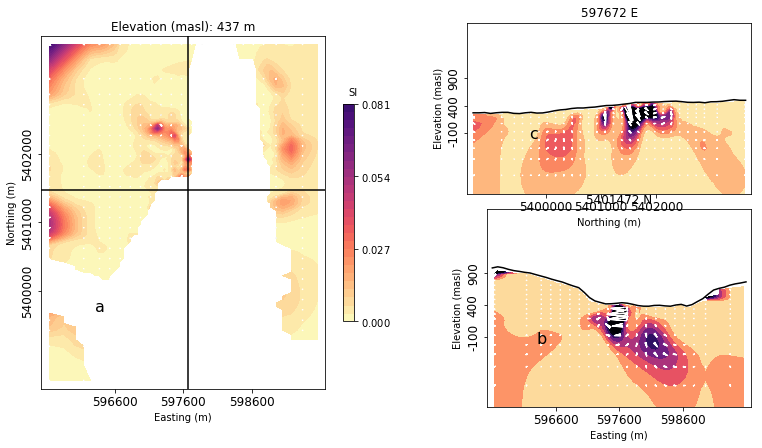

In [31]:
ModSlicer(mesh, model, 'CMI_plot.png', cmap='magma_r', subFact=3)



In [53]:


# # Load synthetic model

# # mod2[~np.isnan(mod2)] +=1e-4

# # Create a magnetization model
# M = PF.Magnetics.dipazm_2_xyz(np.ones(mesh.nC)*30,np.ones(mesh.nC)*-90 )
# M = Utils.sdiag(mod2)*M
# M[mod2==-100,:] = -100
# PF.MagneticsDriver.writeVectorUBC(mesh,'Synthetic.fld',M)

# mod2[mod2==-100]=np.nan
mesh = Mesh.TensorMesh.readUBC("MB_50m_Mesh.txt")
M = PF.Magnetics.readVectorModel(mesh,'Synthetic_v2.fld')

# amp = np.sum(M**2,axis=1)**0.5

# amp[amp>100] = -100
# Mesh.TensorMesh.writeModelUBC(mesh,"Synthetic_dyke.sus",amp)

M[M<-10] = np.nan
# airc = np.isnan(model[:,0])==0
# mod2 = Utils.sdiag(airc)*mod2

In [33]:
# flx = M[:,0].reshape((mesh.vnC), order='F')
# fly = M[:,1].reshape((mesh.vnC), order='F')
# flz = M[:,2].reshape((mesh.vnC), order='F')

# ind1 = np.where((flx>-2) * (flx!=0))
# ind2 = np.where((flx>-2) * (flx!=0))
# ind2[0][:] -= 1

# mx = np.zeros_like(flx)
# my = np.zeros_like(fly)
# mz = np.zeros_like(flz)

# mx[ind2] = flx[ind1]
# my[ind2] = fly[ind1]
# mz[ind2] = flz[ind1]

# m = np.c_[mkvc(mx), mkvc(my), mkvc(mz)]

# indx = M<-10
# m[indx] = -100
# PF.MagneticsDriver.writeVectorUBC(mesh,'Synthetic_v2.fld',m)

In [10]:
# Load data
dobs = PF.Magnetics.readMagneticsObservations("MB_TMI_OBS_50m.prn")
dsim = PF.Magnetics.readMagneticsObservations("Synthetic_dyke.obs")

xyzd = np.c_[dobs.srcField.rxList[0].locs, dobs.dobs]

topo = np.genfromtxt("MB_Topo_50m.topo", skip_header=1)

NameError: name 'M' is not defined

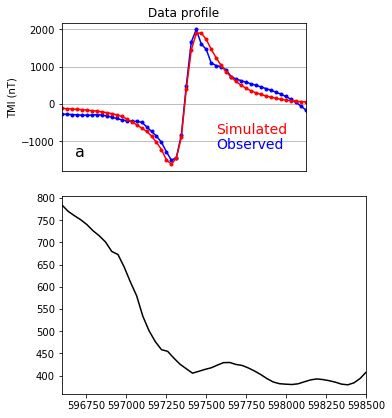

In [17]:
xlim = [596600, 598500]
ylim=[-400,800]

fig = plt.figure(figsize=(12, 8))
ax3 = plt.subplot(2,2,1)
indy = 46
ax3 = PF.Magnetics.plotProfile(xyzd, [596600,mesh.vectorCCy[indy]], [598500,mesh.vectorCCy[indy]], 50,data=dsim.dobs, ax=ax3, fig=fig)
ax3.set_xticks([])
ax3.text(1200,-800,'Simulated', color='r', size=14)
ax3.text(1200,-1200,'Observed', color='b', size=14)
ax3.text(100,-1400,'a', color='k', size=16)
ax3.grid('on')
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0-.025,  pos.width*0.80, pos.height*.75])
ax3.set_ylabel('TMI (nT)')
ax3.set_title('Data profile')

ax1 = plt.subplot(2,2,3)
PF.Magnetics.plotProfile(topo, [596600,mesh.vectorCCy[indy]], [598500,mesh.vectorCCy[indy]],
                         50, ax=ax1, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')

ax1, im, cbar  = plotModelSections(mesh, mkvc(M), normal='y', ind=indy, vmin=0, vmax=0.3,
                      subFact=1, scale=4., xlim=xlim, ylim=ylim, vec='w',
                      title=None, axs=ax1, ndv=-100, contours=[0.1],
                      orientation='vertical', cmap='magma_r')

cbar.set_label('SI',labelpad=-38, y=1.15, rotation=0)
ax1.set_title("Synthetic dyke model")
ax1.set_ylabel('Elevation (masl)')
ax1.set_xlabel('Easting (m)')
x = np.linspace(xlim[0]*1.0001, xlim[1]*0.9999, 3)
ax1.set_xticks(list(map(int, x)))
ax1.set_xticklabels(map(str, map(int, x)),size=12)
ax1.text(596700,-300,'b', color='k', size=16)
        

mesh2 = Mesh.TensorMesh.readUBC('MB_50m_Mesh_v3.txt')
sus = Mesh.TensorMesh.readModelUBC(mesh2,'SimPEG_PF_Inv\\ModelSus_Synthetic.sus')

ax4 = plt.subplot(2,2,4)
sus[sus==-100] = np.nan

PF.Magnetics.plotProfile(topo, [596600,mesh.vectorCCy[indy]], [598500,mesh.vectorCCy[indy]],
                         50, ax=ax4, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')
ax4, im, cbar  = plotModelSections(mesh2, mkvc(sus), normal='y', ind=indy, vmin=0, vmax=0.3,
                      subFact=1, scale=4., xlim=xlim, ylim=ylim, vec='w',
                      title=None, axs=ax4, ndv=-100, contours=None,
                      orientation='vertical', cmap='magma_r')
cbar.remove()
ax4, im, cbar  = plotModelSections(mesh, mkvc(M), normal='y', ind=indy, vmin=0, vmax=0.3,
                      subFact=1, scale=100, xlim=xlim, ylim=ylim, vec='w',
                      title=None, axs=ax4, ndv=-100, contours=[0.1], fill=False,
                      orientation='vertical', cmap='magma_r')

ax4.set_title("Susceptibility model")
ax4.set_yticks([])
ax4.set_xticks(list(map(int, x)))
ax4.set_xticklabels(map(str, map(int, x)),size=12)
ax4.set_xlabel('Easting (m)')
ax4.text(596700,-300,'c', color='k', size=16)



ax2 = plt.subplot(2,2,2)
esus = PF.Magnetics.readVectorModel(mesh2,'SimPEG_MVI_Inv\CMI_VEC.fld')
esus[esus==0] = np.nan

PF.Magnetics.plotProfile(topo, [596600,mesh.vectorCCy[indy]], [598500,mesh.vectorCCy[indy]],
                         50, ax=ax2, fig=fig, coordinate_system = 'xProfile',
                         plotStr='k')

ax2, im, cbar  = plotModelSections(mesh2, mkvc(esus), normal='y', ind=indy, vmin=0, vmax=0.3,
                      subFact=1, scale=4., xlim=xlim, ylim=ylim, vec='w',
                      title=None, axs=ax2, ndv=-100, contours=None,
                      orientation='vertical', cmap='magma_r')
cbar.remove()
plotModelSections(mesh, mkvc(M), normal='y', ind=indy, vmin=0, vmax=0.3,
                      subFact=1, scale=100, xlim=xlim, ylim=ylim, vec='w',
                      title=None, axs=ax2, ndv=-100, contours=[0.1], fill=False,
                      orientation='vertical', cmap='magma_r')
ax2.set_title("CMI model")
ax2.set_xticks([])
ax2.set_ylabel('Elevation (masl)')
pos = ax2.get_position()
ax2.set_position([pos.x0, pos.y0-.075,  pos.width, pos.height])
ax2.text(596700,-300,'d', color='k', size=16)
# ax2.set_xticks(list(map(int, x)))
# ax2.set_xticklabels(map(str, map(int, x)),size=12)

plt.show()
fig.savefig("Simulation.png")